<a href="https://colab.research.google.com/github/HttpYoussef/CodeAlpha_Car-Price-Prediction-with-Machine-Learning/blob/main/Car_Prediction_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score

from sklearn.ensemble import RandomForestRegressor   # strong baseline
import matplotlib.pyplot as plt
import seaborn as sns


In [13]:
df = pd.read_csv("/content/car data.csv")
df.head()
df.info()
df.describe(include='all').T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Driven_kms     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Selling_type   301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Car_Name,301,98,city,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,301.0,NaN,NaN,NaN,2013.627907,2.891554,2003.0,2012.0,2014.0,2016.0,2018.0
Selling_Price,301.0,NaN,NaN,NaN,4.661296,5.082812,0.1,0.9,3.6,6.0,35.0
Present_Price,301.0,NaN,NaN,NaN,7.628472,8.642584,0.32,1.2,6.4,9.9,92.6
Driven_kms,301.0,NaN,NaN,NaN,36947.20598,38886.883882,500.0,15000.0,32000.0,48767.0,500000.0
Fuel_Type,301,3,Petrol,239,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Selling_type,301,2,Dealer,195,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Transmission,301,2,Manual,261,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Owner,301.0,NaN,NaN,NaN,0.043189,0.247915,0.0,0.0,0.0,0.0,3.0


In [14]:
df = df.drop_duplicates()
print(df.isna().sum())


df['car_age'] = 2025 - df['Year']
df = df.drop(columns=['Year'])


y = df['Selling_Price']
X = df.drop(columns=['Selling_Price'])


Car_Name         0
Year             0
Selling_Price    0
Present_Price    0
Driven_kms       0
Fuel_Type        0
Selling_type     0
Transmission     0
Owner            0
dtype: int64


/tmp/ipython-input-14-2314299234.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['car_age'] = 2025 - df['Year']


In [15]:
# 5.1  Identify column types
num_cols = ['Present_Price', 'Driven_kms', 'Owner', 'car_age']

cat_cols = ['Car_Name', 'Fuel_Type', 'Selling_type', 'Transmission']


# 5.2  Preprocess
numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer([
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

# 5.3  Full pipeline with model
model = Pipeline(steps=[
    ('prep', preprocess),
    ('rf',  RandomForestRegressor(
               n_estimators=300,
               max_depth=None,
               random_state=42,
               n_jobs=-1))
])


In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)



Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Present_Price',
                                                   'Driven_kms', 'Owner',
                                                   'car_age']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Car_Name', 'Fuel_Type',
                                                   'Selling_type',
                                                   'Transmission'])])),
                ('rf',
                 RandomForestRegressor(n_estimators=300, n_jobs=-1,
                                       random_state=42))])

In [19]:
y_pred = model.predict(X_test)

mae = round(mean_absolute_error(y_test, y_pred), 2)
r2  = round(r2_score(y_test, y_pred), 3)

print("MAE:", mae, "lakh ₹")
print("R²  :", r2)


MAE: 1.37 lakh ₹
R²  : 0.587


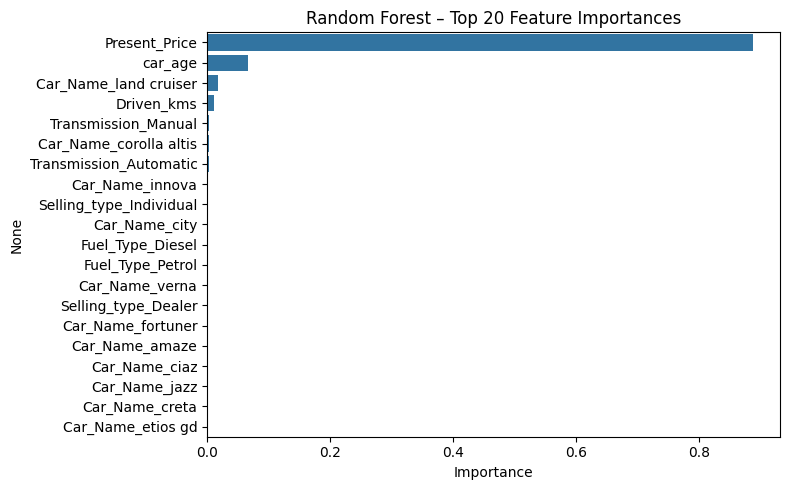

In [20]:
# Get feature names after one‑hot
ohe_feat = list(model.named_steps['prep']
                     .named_transformers_['cat']
                     .named_steps['ohe']
                     .get_feature_names_out(cat_cols))
all_feats = num_cols + ohe_feat

importances = model.named_steps['rf'].feature_importances_
fi = pd.Series(importances, index=all_feats).sort_values(ascending=False)[:20]

plt.figure(figsize=(8,5))
sns.barplot(x=fi.values, y=fi.index)
plt.title("Random Forest – Top 20 Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()
